In [76]:
%load_ext lab_black

In [77]:
from IPython.core.display import HTML

css = (
    open("notebook_css/style-table.css").read()
    + open("notebook_css/style-notebook.css").read()
)
HTML("<style>{}</style>".format(css))

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path

## Load Data

In [79]:
## 🎯🎯🎯🎯🎯
##
## Data Augmentation & Normalization for training data.
## Only Normalization for validation data

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

data_dir = Path("data/hymenoptera_data")
batch_size = 4

our_datasets = {
    i: datasets.ImageFolder(data_dir / i, data_transforms[i])
    for i in ["train", "valid"]
}
our_dataloaders = {
    i: torch.utils.data.DataLoader(
        dataset=our_datasets[i],
        batch_size=batch_size,
        shuffle=True,
    )
    for i in ["train", "valid"]
}
dataset_sizes = {i: len(ds) for i, ds in our_datasets.items()}
class_names = our_datasets["train"].classes

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [80]:
class_names

['ants', 'bees']

In [81]:
dataset_sizes

{'train': 244, 'valid': 153}

## Visualize a few images

In [82]:
## 🎯🎯🎯🎯🎯
##


def imshow(input_, title=None):
    """Imshow for Tensor"""
    input_ = input_.numpy().transpose((-2, -1, -3))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_ = std * input_ + mean
    input_ = np.clip(input_, a_min=0, a_max=1)
    plt.imshow(input_)
    if title:
        plt.title(title)
    plt.show()

torch.Size([4, 3, 224, 224]) torch.Size([4])


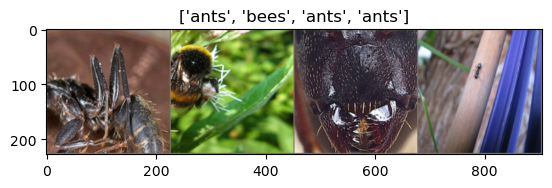

In [83]:
inputs, labels = next(iter(our_dataloaders["train"]))
print(inputs.shape, labels.shape)

inputs_grid = torchvision.utils.make_grid(inputs)
imshow(inputs_grid, title=[class_names[i] for i in labels])

## Training the model

In [84]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    start_time = time.time()
    model_best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("---" * 20)
        print(f"Epoch [{(epoch+1):2d}/{num_epochs:2d}]")
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            elif phase == "valid":
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            ## Iterate over Data
            for xb, yb in our_dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(xb)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, yb)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * xb.shape[0]
                running_corrects += (preds == yb).sum()
            if phase == "train":
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                f"\t [{phase}] | loss: {epoch_loss:.4f} | accuracy: {(100*epoch_acc):.3f}"
            )

            ## deepcopy the best model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                model_best_weights = copy.deepcopy(model.state_dict())

    print("🎯🎯🎯 FINISHED TRAINING")
    print("---" * 25)
    print(f"BEST ACCURACY = {best_acc:.3f}")
    print(f"time elapsed = {time.time() - start_time}")
    print("---" * 25)

## Visualizing the model predictions

In [85]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (xb, yb) in enumerate(our_dataloaders["valid"]):
            preds = model(xb)
            _, preds = torch.max(preds, 1)
            for j in range(xb.shape[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                true_label = class_names[yb[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"[{true_label}] | ({pred_label})")
                imshow(xb[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
num_epochs = 10
model = models.resnet18(pretrained=True)
fc = nn.Linear(model.fc.in_features, 2)
model.fc = fc
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, scheduler, num_epochs)

------------------------------------------------------------
Epoch [ 1/10
	 [train] | loss: 0.5028 | accuracy: 76.639
	 [valid] | loss: 0.2504 | accuracy: 90.850
------------------------------------------------------------
Epoch [ 2/10
	 [train] | loss: 0.5370 | accuracy: 79.098
	 [valid] | loss: 0.5046 | accuracy: 81.699
------------------------------------------------------------
Epoch [ 3/10
	 [train] | loss: 0.5351 | accuracy: 78.689
	 [valid] | loss: 0.2856 | accuracy: 88.889
------------------------------------------------------------
Epoch [ 4/10
	 [train] | loss: 0.4838 | accuracy: 78.279
	 [valid] | loss: 0.7411 | accuracy: 78.431
------------------------------------------------------------
Epoch [ 5/10
	 [train] | loss: 0.4359 | accuracy: 84.426
	 [valid] | loss: 0.3062 | accuracy: 90.850
------------------------------------------------------------
Epoch [ 6/10
	 [train] | loss: 0.4925 | accuracy: 78.689
	 [valid] | loss: 0.3157 | accuracy: 92.157
----------------------------

UnboundLocalError: local variable 'best_acc' referenced before assignment

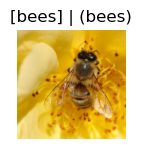

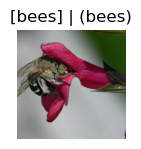

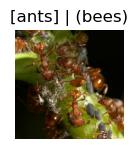

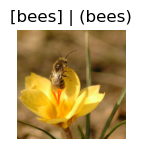

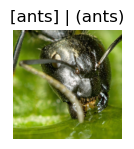

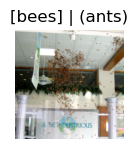

In [20]:
visualize_model(model)

In [86]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
torchvision.models.resnet18??

Signature: torchvision.models.resnet18(pretrained=False, progress=True, **kwargs)
Source:   
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)
File:      ~/anaconda3/lib/python3.7/site-packages/torchvision/models/resnet.py
Type:      function


In [87]:
!bat ~/anaconda3/lib/python3.7/site-packages/torchvision/models/resnet.py

───────┬────────────────────────────────────────────────────────────────────────
       │ File: /Users/imflash217/anaconda3/lib/python3.7/site-packages/torchvision/models/resnet.py
───────┼────────────────────────────────────────────────────────────────────────
   1   │ import torch
   2   │ import torch.nn as nn
   3   │ from .utils import load_state_dict_from_url
   4   │ 
   5   │ 
   6   │ __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
   7   │            'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
   8   │            'wide_resnet50_2', 'wide_resnet101_2']
   9   │ 
  10   │ 
  11   │ model_urls = {
  12   │     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.
       │ pth',
  13   │     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.
       │ pth',
  14   │     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.
       │ pth',
  15   │     'resnet101': 'https://download.pytorch.org/models/resnet1

In [88]:
cls_name = model.__class__.__name__
cls_name

'ResNet'

In [89]:
type(cls_name)

str

In [90]:
def print_clsname(module):
    print("🎯", module.__class__.__name__)

In [91]:
model.apply(print_clsname)

🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 MaxPool2d
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 BasicBlock
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 BasicBlock
🎯 Sequential
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 Conv2d
🎯 BatchNorm2d
🎯 Sequential
🎯 BasicBlock
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 BasicBlock
🎯 Sequential
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 Conv2d
🎯 BatchNorm2d
🎯 Sequential
🎯 BasicBlock
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 BasicBlock
🎯 Sequential
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 Conv2d
🎯 BatchNorm2d
🎯 Sequential
🎯 BasicBlock
🎯 Conv2d
🎯 BatchNorm2d
🎯 ReLU
🎯 Conv2d
🎯 BatchNorm2d
🎯 BasicBlock
🎯 Sequential
🎯 AdaptiveAvgPool2d
🎯 Linear
🎯 ResNet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
nn.BatchNorm2d?

Init signature:
nn.BatchNorm2d(
    num_features,
    eps=1e-05,
    momentum=0.1,
    affine=True,
    track_running_stats=True,
)
Docstring:     
Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs
with additional channel dimension) as described in the paper
`Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .

.. math::

    y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta

The mean and standard-deviation are calculated per-dimension over
the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
of size `C` (where `C` is the input size). By default, the elements of :math:`\gamma` are set
to 1 and the elements of :math:`\beta` are set to 0. The standard-deviation is calculated
via the biased estimator, equivalent to `torch.var(input, unbiased=False)`.

Also by default, during training this layer keeps running estimates of its

In [40]:
nn.DataParallel?

Init signature: nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
Docstring:     
Implements data parallelism at the module level.

This container parallelizes the application of the given :attr:`module` by
splitting the input across the specified devices by chunking in the batch
dimension (other objects will be copied once per device). In the forward
pass, the module is replicated on each device, and each replica handles a
portion of the input. During the backwards pass, gradients from each replica
are summed into the original module.

The batch size should be larger than the number of GPUs used.

.. warning::
    It is recommended to use :class:`~torch.nn.parallel.DistributedDataParallel`,
    instead of this class, to do multi-GPU training, even if there is only a single
    node. See: :ref:`cuda-nn-ddp-instead` and :ref:`ddp`.

Arbitrary positional and keyword inputs are allowed to be passed into
DataParallel but some types are specially handled. tensors will be
*

In [41]:
torch.full?

Docstring:
full(size, fill_value, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Creates a tensor of size :attr:`size` filled with :attr:`fill_value`. The
tensor's dtype is inferred from :attr:`fill_value`.

Args:
    size (int...): a list, tuple, or :class:`torch.Size` of integers defining the
        shape of the output tensor.
    fill_value (Scalar): the value to fill the output tensor with.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device of returned tensor.
        Default: if ``None``, uses the current device for the default tensor type
        (see :func:`tor

In [45]:
torch.rand?

Docstring:
rand(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with random numbers from a uniform distribution
on the interval :math:`[0, 1)`

The shape of the tensor is defined by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device of returned tensor.
        Default: if ``None``, uses the current device for the default tensor type


In [50]:
torch.Tensor.fill_??

Docstring:
fill_(value) -> Tensor

Fills :attr:`self` tensor with the specified value.
Type:      method_descriptor


In [51]:
torch.Tensor.detach??

Docstring:
Returns a new Tensor, detached from the current graph.

The result will never require gradient.

.. note::

  Returned Tensor shares the same storage with the original one.
  In-place modifications on either of them will be seen, and may trigger
  errors in correctness checks.
  IMPORTANT NOTE: Previously, in-place size / stride / storage changes
  (such as `resize_` / `resize_as_` / `set_` / `transpose_`) to the returned tensor
  also update the original tensor. Now, these in-place changes will not update the
  original tensor anymore, and will instead trigger an error.
  For sparse tensors:
  In-place indices / values changes (such as `zero_` / `copy_` / `add_`) to the
  returned tensor will not update the original tensor anymore, and will instead
  trigger an error.
Type:      method_descriptor


In [52]:
plt.imshow?

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    *,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image, i.e., on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. For displaying a grayscale
image set up the color mapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

The number of pixels used to render an image is set by the axes size
and the *dpi* of the figure. This can lead to aliasing artifacts when
the image is resampled because the displayed image size will usually
not match the size of *X* (see
:doc:`/gallery/images_contours_and_fields/image_antialiasing`).
The resampling can be controlled via the *interpolation* parameter
and/or :rc:`image.interpolation`.

Parameters

In [53]:
import matplotlib

In [54]:
matplotlib.animation.ArtistAnimation?

Init signature: matplotlib.animation.ArtistAnimation(fig, artists, *args, **kwargs)
Docstring:     
Animation using a fixed set of `.Artist` objects.

Before creating an instance, all plotting should have taken place
and the relevant artists saved.

Parameters
----------
fig : `~matplotlib.figure.Figure`
    The figure object used to get needed events, such as draw or resize.
artists : list
    Each list entry is a collection of artists that are made visible on
    the corresponding frame.  Other artists are made invisible.
interval : int, default: 200
    Delay between frames in milliseconds.
repeat_delay : int, default: 0
    The delay in milliseconds between consecutive animation runs, if
    *repeat* is True.
repeat : bool, default: True
    Whether the animation repeats when the sequence of frames is completed.
blit : bool, default: False
    Whether blitting is used to optimize drawing.
File:           ~/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py
Type:         

In [55]:
matplotlib.animation.ArtistAnimation.to_jshtml?

Signature:
matplotlib.animation.ArtistAnimation.to_jshtml(
    self,
    fps=None,
    embed_frames=True,
    default_mode=None,
)
Docstring: Generate HTML representation of the animation
File:      ~/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py
Type:      function


In [58]:
torch.nn.functional.affine_grid?

Signature: torch.nn.functional.affine_grid(theta, size, align_corners=None)
Docstring:
Generates a 2D or 3D flow field (sampling grid), given a batch of
affine matrices :attr:`theta`.

.. note::
    This function is often used in conjunction with :func:`grid_sample`
    to build `Spatial Transformer Networks`_ .

Args:
    theta (Tensor): input batch of affine matrices with shape
        (:math:`N \times 2 \times 3`) for 2D or
        (:math:`N \times 3 \times 4`) for 3D
    size (torch.Size): the target output image size.
        (:math:`N \times C \times H \times W` for 2D or
        :math:`N \times C \times D \times H \times W` for 3D)
        Example: torch.Size((32, 3, 24, 24))
    align_corners (bool, optional): if ``True``, consider ``-1`` and ``1``
        to refer to the centers of the corner pixels rather than the image corners.
        Refer to :func:`grid_sample` for a more complete description.
        A grid generated by :func:`affine_grid` should be passed to :func:`grid

In [8]:
torch.nn.functional.grid_sample?

Signature:
torch.nn.functional.grid_sample(
    input,
    grid,
    mode='bilinear',
    padding_mode='zeros',
    align_corners=None,
)
Docstring:
Given an :attr:`input` and a flow-field :attr:`grid`, computes the
``output`` using :attr:`input` values and pixel locations from :attr:`grid`.

Currently, only spatial (4-D) and volumetric (5-D) :attr:`input` are
supported.

In the spatial (4-D) case, for :attr:`input` with shape
:math:`(N, C, H_\text{in}, W_\text{in})` and :attr:`grid` with shape
:math:`(N, H_\text{out}, W_\text{out}, 2)`, the output will have shape
:math:`(N, C, H_\text{out}, W_\text{out})`.

For each output location ``output[n, :, h, w]``, the size-2 vector
``grid[n, h, w]`` specifies :attr:`input` pixel locations ``x`` and ``y``,
which are used to interpolate the output value ``output[n, :, h, w]``.
In the case of 5D inputs, ``grid[n, d, h, w]`` specifies the
``x``, ``y``, ``z`` pixel locations for interpolating
``output[n, :, d, h, w]``. :attr:`mode` argument specifi